Exploring common exoplanet discovery methods

First we'll run through some notebook, plotting, and data setup, before taking a look at correlations between parameters of discovered exoplanets, and the methods used to discover them.

In [1]:
# Loading in some useful toolsets for plotting and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from math import sqrt

# For reading in data tables and manipulating units in calculations
import astropy.io.ascii
import astropy.constants as ac
import astropy.units as u

# Tool for automating style changes between data on same plot
from cycler import cycler

In [2]:
# Create a dictionary with updated parameters for
# the default matplotlib style.

# Set our tables to differentiate marker styles automatically for shared plots
default_cycler = (cycler(color=['tab:blue', 'tab:orange', 'tab:red', 'tab:green','tab:purple']) +
                  cycler(marker=['o', 'v', '+', '.','1']))

for d in default_cycler:
    print(d)

style_revisions = {
 'axes.linewidth':  1.5, 
 'xtick.top' : True,         
 'xtick.minor.top': True,
 'xtick.minor.bottom': True,
 'ytick.right' :  True,
 'xtick.direction' : 'in',    
 'ytick.direction' : 'in', 
 'xtick.major.size' : 11,     
 'ytick.major.size' : 11,
 'xtick.minor.size' : 5.5,    
 'ytick.minor.size' : 5.5,      
 'font.size' : 16,              
 'figure.figsize' : [13, 10],
 'lines.linewidth' : 2.,
 'axes.prop_cycle': default_cycler,
}

# Update the matplotlib dictionary
plt.rcParams.update(style_revisions)

# Show all of the potential rcParams
#plt.rcParams.keys()

{'color': 'tab:blue', 'marker': 'o'}
{'color': 'tab:orange', 'marker': 'v'}
{'color': 'tab:red', 'marker': '+'}
{'color': 'tab:green', 'marker': '.'}
{'color': 'tab:purple', 'marker': '1'}


In [3]:
# Read in exoplanet data and convert astropy Table to pandas DataFrame for easier manipulation
tab = astropy.io.ascii.read("data/PS_2022.01.23_19.24.57.csv")
df = tab.to_pandas()

# Preview loaded basic solar system planet data
df.head(2)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06


In [4]:
# Read in basic solar system data
solsys = pd.read_csv("data/solsys.csv")
solsys = solsys[ solsys["pl_controv_flag"] == 1 ]

# Preview loaded basic solar system planet data
solsys.head(2)

,pl_solsys,pl_controv_flag,period_days,mass_e,mass_j,semi_ma,rad_km,mass_kg,rad_e,rad_j
0,mercury,1,88.0,0.055274,0.000174,0.4,2439.7,3.301040e+23,0.055274,0.000174
1,venus,1,225.0,0.814998,0.002564,0.7,6051.8,4.867320e+24,0.814998,0.002564


In [5]:
# Lists all of the column identifiers in the exoplanet data file
#print(tab.colnames)

In [6]:
# List all of the disovery methods loaded from the dataset 
for n, dm in df.groupby('discoverymethod', sort=True):
    print( n, len(dm) )

Astrometry 1
Disk Kinematics 1
Eclipse Timing Variations 16
Imaging 57
Microlensing 121
Orbital Brightness Modulation 9
Pulsar Timing 7
Pulsation Timing Variations 2
Radial Velocity 912
Transit 3755
Transit Timing Variations 22


In [8]:
# Simplify the dataframe of exoplanet data to only include the transit methods relevant to this project
#### Comment out the line below and rerun notebook to plot *all* of the (loaded) exoplanets
df = df[ df['discoverymethod'].isin(["Transit", "Radial Velocity", "Imaging"]) ]

# Show the detection methods used for the rest of the notebook
for n, dm in df.groupby('discoverymethod', sort=True):
    print( n, len(dm) )

Imaging 57
Radial Velocity 912
Transit 3755


In [9]:
# Using some singular and nested dictionaries,
#  we can create a master style sheet for all of the plot markers we'll use

# Style properties common to solar system planets
solsys_base_style = dict(markersize=18, markerfacecolor="orangered", markeredgecolor="none", markeredgewidth=0)

# Style properties unique to each detection method and solar system planet
mark = {
    # Marker styling for solar system planets
    'mercury':dict(marker='$\u263F$', **solsys_base_style),
    'venus':dict(marker='$\u2640$', **solsys_base_style),
    'earth':dict(marker='$\u2295$', **solsys_base_style),
    'mars':dict(marker='$\u2642$', **solsys_base_style),
    'jupiter':dict(marker='$\u2643$', **solsys_base_style),
    'saturn':dict(marker='$\u2644$', **solsys_base_style),
    'uranus':dict(marker='$\u26E2$', **solsys_base_style),
    'neptune':dict(marker='$\u2646$', **solsys_base_style),
    'pluto':dict(marker='$\u2BD3$', **solsys_base_style),
    
    # Marker styling for exoplanet detection methods
    #### This project focuses on Transit, Radial Velocity, and Imaging; but, data for all are loaded
    'Transit':dict(marker="s", ms=7, mec='mediumspringgreen', mew='1.5', label="Transit"), # 3755
    'Radial Velocity':dict(marker="x", ms=8, mec='steelblue', mew='2', label="Radial Velocity"), # 912
    'Imaging':dict(marker="+", ms=11, mec='darkgoldenrod', mew='1.5', label="Imaging"), # 57
    
    'Microlensing':dict(marker=".", ms=5, mec='k', mew='2'), # 121
    'Transit Timing Variations':dict(marker=".", ms=5, mec='k', mew='2'), # 22
    'Eclipse Timing Variations':dict(marker=".", ms=5, mec='k', mew='2'), # 16
    'Orbital Brightness Modulation':dict(marker=".", ms=5, mec='k', mew='2'), # 9
    'Pulsar Timing':dict(marker=".", ms=5, mec='k', mew='2'), # 7
    'Pulsation Timing Variations':dict(marker=".", ms=5, mec='k', mew='2'), # 2    
    'Disk Kinematics':dict(marker=".", ms=5, mec='k', mew='2'), # 1
    'Astrometry':dict(marker=".", ms=5, mec='k', mew='2'), # 1
}

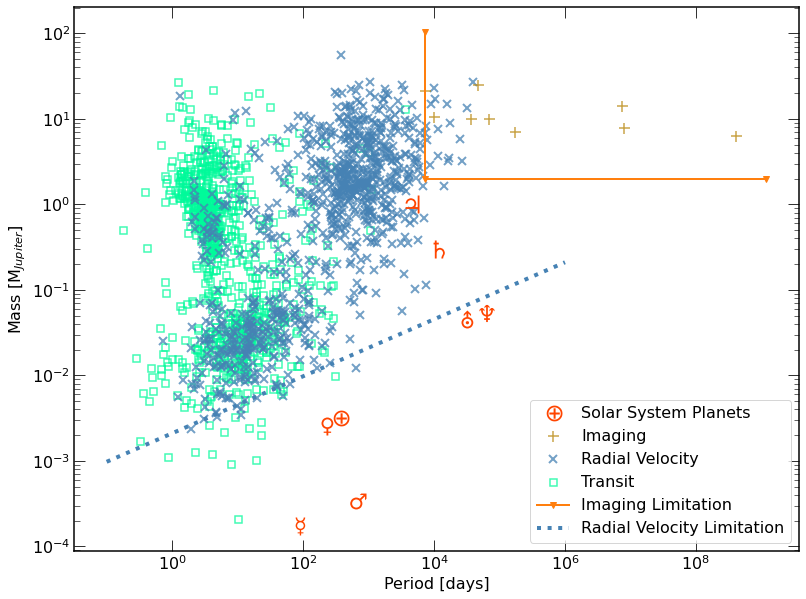

In [10]:
for method, dm in df.groupby('discoverymethod'):
    plt.plot(dm["pl_orbper"], dm["pl_bmassj"], ls="none", mfc="none", **mark[method], alpha=0.75, zorder=-len(dm))
for idx, pl in solsys.iterrows():
    plt.plot( pl.period_days, pl.mass_j, **mark[pl.pl_solsys], zorder=2)
solsys_label = mlines.Line2D([], [], linestyle='none', **mark["earth"], label='Solar System Planets')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period [days]")
plt.ylabel(r"Mass [M$_{Jupiter}$]")


####
# Imaging
max_x = plt.gca().get_xlim()[1]
max_y = plt.gca().get_ylim()[1]
min_x = df[ df["discoverymethod"] == "Imaging" ].pl_orbper.min()
min_y = df[ df["discoverymethod"] == "Imaging" ].pl_bmassj.min()
plt.plot( [min_x, min_x, max_x], [max_y, min_y, min_y], label="Imaging Limitation" )


####
# Radial
sol_mass = 0.5
K_val = 0.5

# x axis for period plots
per_arr = 10.0**(np.arange(8)-1) * u.day

# y axis for with period for the x axis
m_p_arr_per = K_val * u.meter / u.second * sol_mass * u.solMass * np.sqrt(((per_arr**2)*ac.G*(sol_mass * u.solMass)/2/np.pi)**(1/3) / ac.G / (sol_mass * u.solMass))

plt.plot(per_arr.value, m_p_arr_per.decompose().to(u.jupiterMass), marker="None", c='steelblue', lw=4, label="Radial Velocity Limitation", ls=":" )

####
# Transit


####
# Get all the legend icons made by default
handles, labels = plt.gca().get_legend_handles_labels()
# Update legend to include custom icon alongside existing icons
plt.gca().legend(handles = [solsys_label] + handles, loc="lower right")

plt.savefig( "figures/jup_mass_vs_orbital_per.png" )

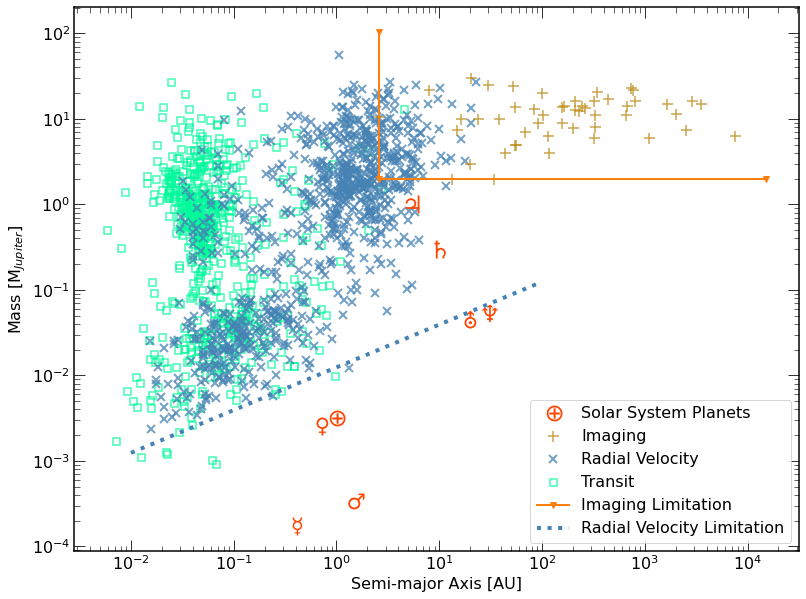

In [11]:
for method, dm in df.groupby('discoverymethod'):
    plt.plot(dm["pl_orbsmax"], dm["pl_bmassj"], ls="none", mfc="none", **mark[method], alpha=0.75, zorder=-len(dm))
for idx, pl in solsys.iterrows():
    plt.plot( pl.semi_ma, pl.mass_j, **mark[pl.pl_solsys], zorder=2)
solsys_label = mlines.Line2D([], [], linestyle='none', **mark["earth"], label='Solar System Planets')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Semi-major Axis [AU]")
plt.ylabel(r"Mass [M$_{Jupiter}$]")


####
# Imaging
max_x = plt.gca().get_xlim()[1]
max_y = plt.gca().get_ylim()[1]
min_x = df[ df["discoverymethod"] == "Imaging" ].pl_orbsmax.min()
min_y = df[ df["discoverymethod"] == "Imaging" ].pl_bmassj.min()
plt.plot( [min_x, min_x, max_x], [max_y, min_y, min_y], label="Imaging Limitation" )


####
# Radial
# x-axis (semi-major axis) for a continuous line
sma_arr = 10.0**(np.arange(5)-2) * u.AU


# y axis mass fo the planet determined by equations above
m_p_arr_sma = K_val * u.meter / u.second * sol_mass * u.solMass * np.sqrt(sma_arr / ac.G / (sol_mass * u.solMass))

# Plotting the line
plt.plot(sma_arr.value, m_p_arr_sma.decompose().to(u.jupiterMass), marker="None", c='steelblue', lw=4, label="Radial Velocity Limitation", ls=":" )


####
# Transit


####
# Get all the legend icons made by default
handles, labels = plt.gca().get_legend_handles_labels()
# Update legend to include custom icon alongside existing icons
plt.gca().legend(handles = [solsys_label] + handles, loc="lower right")

plt.savefig( "figures/jup_mass_vs_semi_ma.png" )

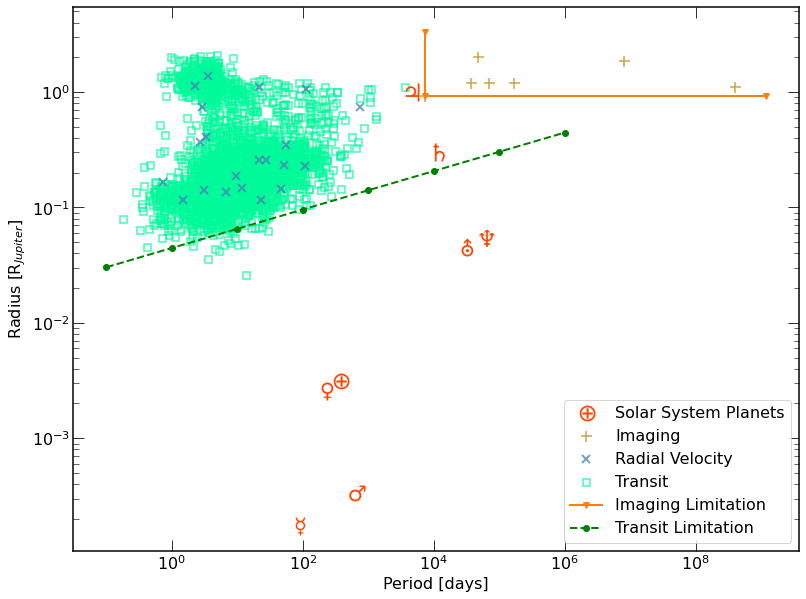

In [12]:
for method, dm in df.groupby('discoverymethod'):
    plt.plot(dm["pl_orbper"], dm["pl_radj"], ls="none", mfc="none", **mark[method], alpha=0.75, zorder=-len(dm))
for idx, pl in solsys.iterrows():
    plt.plot( pl.period_days, pl.rad_j, **mark[pl.pl_solsys], zorder=2)
solsys_label = mlines.Line2D([], [], linestyle='none', **mark["earth"], label='Solar System Planets')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period [days]")
plt.ylabel(r"Radius [R$_{Jupiter}$]")


####
# Imaging
max_x = plt.gca().get_xlim()[1]
max_y = plt.gca().get_ylim()[1]
min_x = df[ df["discoverymethod"] == "Imaging" ].pl_orbper.min()
min_y = df[ df["discoverymethod"] == "Imaging" ].pl_radj.min()
plt.plot( [min_x, min_x, max_x], [max_y, min_y, min_y], label="Imaging Limitation" )


####
# Radial


####
# Transit
period_arr = 10.0**(np.arange(8)-1) * u.day

jupiter_density = 1.3 #g/cm^3
sol_density = 1.41 #g/cm^3
jupiter_period = 4332*u.day #days
snr_base = 9 # signal-to-noise ratio
sigma = 1.2e-5 # transit depth sensitivity
n_tr = 90*u.day / period_arr # number of transits over the duration of an observation
t_dur = 13*u.hour.to(u.day) * (period_arr / (1*u.year).to(u.day))**(1/3) * (sol_density/jupiter_density)**(-1/3) # optimal transit duration
bin_interval = 6*u.hour.to(u.day) # binning interval

delta = snr_base * sigma * np.sqrt( n_tr * t_dur / bin_interval )**(-1) # 

r_p = np.sqrt( delta ) * u.solRad
r_p = r_p.to(u.jupiterRad)

plt.plot( period_arr, r_p, "go--", label="Transit Limitation" )


####
# Get all the legend icons made by default
handles, labels = plt.gca().get_legend_handles_labels()
# Update legend to include custom icon alongside existing icons
plt.gca().legend(handles = [solsys_label] + handles, loc="lower right")

plt.savefig( "figures/jup_rad_vs_orbital_per.png" )

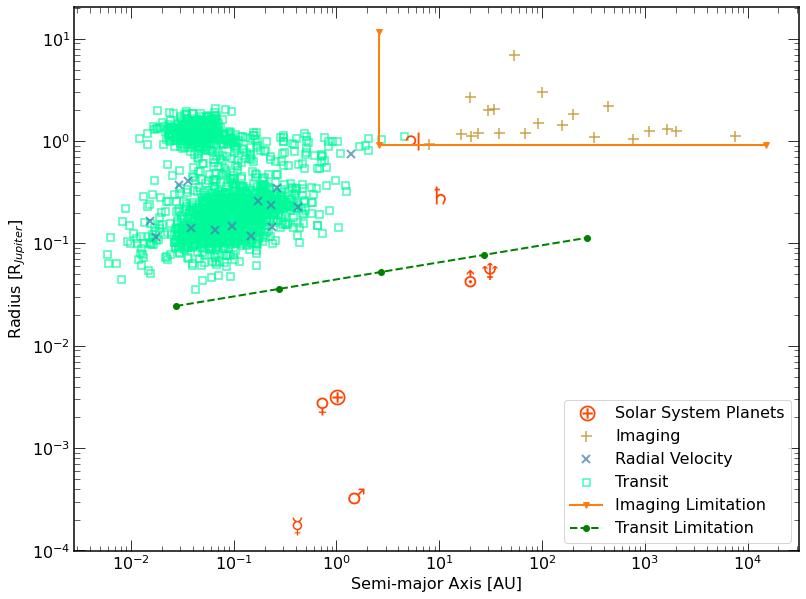

In [13]:
for method, dm in df.groupby('discoverymethod'):
    plt.plot(dm["pl_orbsmax"], dm["pl_radj"], ls="none", mfc="none", **mark[method], alpha=0.75, zorder=-len(dm))
for idx, pl in solsys.iterrows():
    plt.plot( pl.semi_ma, pl.rad_j, **mark[pl.pl_solsys], zorder=2)
solsys_label = mlines.Line2D([], [], linestyle='none', **mark["earth"], label='Solar System Planets')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Semi-major Axis [AU]")
plt.ylabel(r"Radius [R$_{Jupiter}$]")


####
# Imaging
max_x = plt.gca().get_xlim()[1]
max_y = plt.gca().get_ylim()[1]
min_x = df[ df["discoverymethod"] == "Imaging" ].pl_orbsmax.min()
min_y = df[ df["discoverymethod"] == "Imaging" ].pl_radj.min()
plt.plot( [min_x, min_x, max_x], [max_y, min_y, min_y], label="Imaging Limitation" )


####
# Radial


#### PLACEHOLDER ####
# Transit
period_arr = 10.0**(np.arange(2,7)-1) * u.day / 365

jupiter_density = 1.3 #g/cm^3
sol_density = 1.41 #g/cm^3
jupiter_period = 4332*u.day #days
snr_base = 9 # signal-to-noise ratio
sigma = 1.2e-5 # transit depth sensitivity
n_tr = 90*u.day / period_arr # number of transits over the duration of an observation
t_dur = 13*u.hour.to(u.day) * (period_arr / (1*u.year).to(u.day))**(1/3) * (sol_density/jupiter_density)**(-1/3) # optimal transit duration
bin_interval = 6*u.hour.to(u.day) # binning interval

delta = snr_base * sigma * np.sqrt( n_tr * t_dur / bin_interval )**(-1) # 

r_p = np.sqrt( delta ) * u.solRad
r_p = r_p.to(u.jupiterRad)

plt.plot( period_arr, r_p, "go--", label="Transit Limitation" )
#### PLACEHOLDER ####


####
# Get all the legend icons made by default
handles, labels = plt.gca().get_legend_handles_labels()
# Update legend to include custom icon alongside existing icons
plt.gca().legend(handles = [solsys_label] + handles, loc="lower right")

plt.savefig( "figures/jup_rad_vs_semi_ma.png" )